In [1]:
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import gradio as gr
import cv2
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
import copy
import os
import random
import splitfolders

c:\Users\omerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir = r"C:/Users/omerf/birads_split/train"
val_dir   = r"C:/Users/omerf/birads_split/val"
test_dir  = r"C:/Users/omerf/birads_split/test"


In [3]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])


In [4]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir, transform=val_tf)
test_ds  = datasets.ImageFolder(test_dir, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = True     


model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
#best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())



In [ ]:
best_acc = 0.90
EPOCHS = 0 #already run 60 times

In [17]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))

C:\Users\omerf\AppData\Local\Temp\ipykernel_13080\2886250097.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

<All keys matched successfully>

In [ ]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Train Loss: {total_loss:.4f}")

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            _, pred_class = preds.max(1)

            correct += (pred_class == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")


    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_model.pth")
        print(">>> Saved new best model!")


model.load_state_dict(best_model_wts)


In [ ]:
model.eval()
correct = 0
total = 0
model.load_state_dict(torch.load("best_model.pth", map_location=device))

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        _, pred_class = preds.max(1)

        correct += (pred_class == labels).sum().item()
        total += labels.size(0)



In [ ]:
print("TEST ACCURACY:", correct / total)

TEST ACCURACY: 0.9768000000000001


<Figure size 600x600 with 0 Axes>

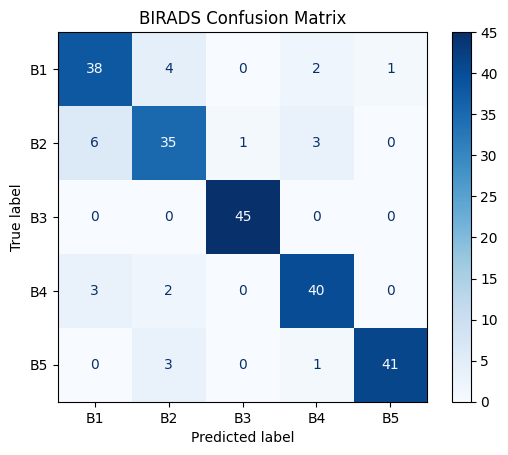

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["B1","B2","B3","B4","B5"])

plt.figure(figsize=(6,6))
disp.plot(values_format="d", cmap="Blues")
plt.title("BIRADS Confusion Matrix")
plt.show()
